In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import tqdm
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

Создадим класс датасета.

Изображения будем ресайзить к размеру 32x50 px, в качестве нормализации будет делить значения пикселей на 255

In [7]:
class AutoencoderImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, ann_file=None):
        self.transform = transform
        self.img_dir = img_dir
        self.img_names = os.listdir(self.img_dir)
        if ann_file:
            with open(ann_file, 'r') as f:
                lines = f.readlines()
            self.labels = {k: int(v) for k, v in map(lambda x: list(x.split(' ')), lines)}
        else:
            self.labels = {k: 0 for k in self.img_names}

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = cv2.imread(img_path)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[self.img_names[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
transforms = v2.Compose([
    v2.Resize((32, 50)),
    v2.Normalize(mean=[0, 0, 0], std=[255., 255., 255.]),
])
dataset = AutoencoderImageDataset('./dataset/train', transforms)

В качестве модели возьмем немного модифицированный VariationalAutoencoder из лекции

In [9]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(32*50*3, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 32*50*3)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 32, 50))

In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [36]:
# Train loop c логгированием значения лосса в tensorboard
def train(autoencoder, data, run_dir, epochs=20, kl_coef=0.01):
    writer = SummaryWriter(log_dir=f'./logs/{run_dir}')
    opt = torch.optim.Adam(autoencoder.parameters())
    iter_counter = 0
    for epoch in tqdm.tqdm(range(epochs)):
        epoch_losses = []
        for x, y in data:
            x = x.to(DEVICE) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = F.mse_loss(x_hat, x, reduction='sum') + autoencoder.encoder.kl*kl_coef
            epoch_losses.append(loss.cpu().item())
            writer.add_scalar("loss/iter", loss.cpu().item(), iter_counter)
            loss.backward()
            opt.step()
            iter_counter += 1
        m_loss = np.mean(epoch_losses)
        print(f"Epoch mean loss: {m_loss}")
        writer.add_scalar("loss/epoch", m_loss, epoch)
    return autoencoder

In [37]:
latent_dims = 10
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
vae = VariationalAutoencoder(latent_dims=latent_dims).to(DEVICE) # GPU

In [38]:
vae = train(vae, dataloader, 'exp1')

  5%|▌         | 1/20 [00:01<00:26,  1.41s/it]

Epoch mean loss: 107.4560410949707


 10%|█         | 2/20 [00:02<00:25,  1.40s/it]

Epoch mean loss: 68.4093450378418


 15%|█▌        | 3/20 [00:04<00:24,  1.42s/it]

Epoch mean loss: 54.19936902770996


 20%|██        | 4/20 [00:05<00:22,  1.40s/it]

Epoch mean loss: 45.09383551940918


 25%|██▌       | 5/20 [00:06<00:20,  1.35s/it]

Epoch mean loss: 38.730580453491214


 30%|███       | 6/20 [00:08<00:18,  1.34s/it]

Epoch mean loss: 36.76137222290039


 35%|███▌      | 7/20 [00:09<00:17,  1.34s/it]

Epoch mean loss: 33.08977306823731


 40%|████      | 8/20 [00:10<00:15,  1.33s/it]

Epoch mean loss: 31.225208654785156


 45%|████▌     | 9/20 [00:12<00:14,  1.32s/it]

Epoch mean loss: 29.31472304992676


 50%|█████     | 10/20 [00:13<00:13,  1.32s/it]

Epoch mean loss: 28.667397201538087


 55%|█████▌    | 11/20 [00:14<00:11,  1.32s/it]

Epoch mean loss: 27.99215919494629


 60%|██████    | 12/20 [00:16<00:10,  1.32s/it]

Epoch mean loss: 27.082687612915038


 65%|██████▌   | 13/20 [00:17<00:09,  1.33s/it]

Epoch mean loss: 25.995070806884765


 70%|███████   | 14/20 [00:18<00:08,  1.36s/it]

Epoch mean loss: 26.406413177490233


 75%|███████▌  | 15/20 [00:20<00:06,  1.36s/it]

Epoch mean loss: 25.638499838256838


 80%|████████  | 16/20 [00:21<00:05,  1.36s/it]

Epoch mean loss: 25.095798330688478


 85%|████████▌ | 17/20 [00:22<00:04,  1.36s/it]

Epoch mean loss: 24.618009436035155


 90%|█████████ | 18/20 [00:24<00:02,  1.36s/it]

Epoch mean loss: 24.323811779785157


 95%|█████████▌| 19/20 [00:25<00:01,  1.36s/it]

Epoch mean loss: 24.313219470214843


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]

Epoch mean loss: 23.379361611938478


In [39]:
dataset_proliv = AutoencoderImageDataset('./dataset/proliv', transforms)
dataloader_proliv = DataLoader(dataset_proliv, batch_size=16, shuffle=True)

Среднее значение MSE на тренировочных данных без проливов после обучения

In [40]:

vae.eval()
loss_sum = 0
with torch.no_grad():
    for x, y in dataloader:
        x = x.to(DEVICE) # GPU
        x_hat = vae(x)
        loss = F.mse_loss(x_hat, x, reduction='sum')
        loss_sum += loss.cpu().item()
print(loss_sum/len(dataset))


1.1198608067512512


Минимальное значение MSE на изображениях из dataset\proliv с проливами

In [41]:

dataloader_proliv = DataLoader(dataset_proliv, batch_size=1, shuffle=False)
vae.eval()
losses = []
with torch.no_grad():
    for x, y in dataloader_proliv:
        x = x.to(DEVICE) # GPU
        x_hat = vae(x)
        loss = F.mse_loss(x_hat, x, reduction='sum')
        losses.append(loss.cpu().item())

min(losses)


8.658788681030273

In [42]:
from sklearn import metrics
def test(model, dataloader, mse_thr):
    model.eval()
    targets = []
    preds = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE) # GPU
            x_hat = model(x)
            loss = F.mse_loss(x_hat, x, reduction='sum').cpu().item()
            targets.extend(y)
            preds.append(1 if loss > mse_thr else 0 )
    print(metrics.confusion_matrix(targets, preds))
    print(metrics.classification_report(targets, preds))
    

In [43]:
dataset_test = AutoencoderImageDataset('./dataset/test/imgs', transforms, ann_file='./dataset/test/test_annotation.txt')
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)



Посчитаем метрики с подобранным порогом MSE

True positive rate - это recall класса 1 (есть пролив), True negative rate - это recall класса 0 (нет пролива)

In [44]:
test(vae, dataloader_test, 8.7)

[[2893  772]
 [  21  108]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3665
           1       0.12      0.84      0.21       129

    accuracy                           0.79      3794
   macro avg       0.56      0.81      0.55      3794
weighted avg       0.96      0.79      0.86      3794



Попробуем улучшить метрики, повысив коэффициент расстояния Кульбака — Лейблера

In [45]:
latent_dims = 10
vae = VariationalAutoencoder(latent_dims=latent_dims).to(DEVICE) # GPU

In [46]:
vae = train(vae, dataloader, 'exp2', kl_coef=1)

  0%|          | 0/20 [00:00<?, ?it/s]/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

Epoch mean loss: 192.1221573730469


 10%|█         | 2/20 [00:02<00:25,  1.41s/it]

Epoch mean loss: 174.77283312988283


 15%|█▌        | 3/20 [00:04<00:23,  1.39s/it]

Epoch mean loss: 172.5835478027344


 20%|██        | 4/20 [00:05<00:22,  1.42s/it]

Epoch mean loss: 171.68721427001952


 25%|██▌       | 5/20 [00:07<00:21,  1.41s/it]

Epoch mean loss: 171.3058934814453


 30%|███       | 6/20 [00:08<00:19,  1.41s/it]

Epoch mean loss: 171.1573019165039


 35%|███▌      | 7/20 [00:09<00:18,  1.45s/it]

Epoch mean loss: 170.39398991699218


 40%|████      | 8/20 [00:11<00:17,  1.45s/it]

Epoch mean loss: 170.35038294677733


 45%|████▌     | 9/20 [00:13<00:16,  1.54s/it]

Epoch mean loss: 169.77851072998047


 50%|█████     | 10/20 [00:14<00:15,  1.52s/it]

Epoch mean loss: 169.63453322753907


 55%|█████▌    | 11/20 [00:16<00:13,  1.50s/it]

Epoch mean loss: 168.96801049804688


 60%|██████    | 12/20 [00:17<00:11,  1.47s/it]

Epoch mean loss: 168.9544078857422


 65%|██████▌   | 13/20 [00:18<00:10,  1.44s/it]

Epoch mean loss: 168.4282329345703


 70%|███████   | 14/20 [00:20<00:08,  1.43s/it]

Epoch mean loss: 168.06585134277344


 75%|███████▌  | 15/20 [00:21<00:07,  1.42s/it]

Epoch mean loss: 167.57244959716797


 80%|████████  | 16/20 [00:23<00:05,  1.40s/it]

Epoch mean loss: 167.38833896484374


 85%|████████▌ | 17/20 [00:24<00:04,  1.40s/it]

Epoch mean loss: 167.91920167236327


 90%|█████████ | 18/20 [00:25<00:02,  1.39s/it]

Epoch mean loss: 167.59147641601564


 95%|█████████▌| 19/20 [00:27<00:01,  1.38s/it]

Epoch mean loss: 166.85424455566405


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

Epoch mean loss: 167.4312610107422


In [47]:

dataloader_proliv = DataLoader(dataset_proliv, batch_size=1, shuffle=False)
vae.eval()
losses = []
with torch.no_grad():
    for x, y in dataloader_proliv:
        x = x.to(DEVICE) # GPU
        x_hat = vae(x)
        loss = F.mse_loss(x_hat, x, reduction='sum')
        losses.append(loss.cpu().item())

min(losses)


17.074199676513672

Как можно заметить, метрики улучшились

True positive rate - это recall класса 1 (есть пролив), True negative rate - это recall класса 0 (нет пролива)

In [48]:
test(vae, dataloader_test, 17)

[[2987  678]
 [  10  119]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3665
           1       0.15      0.92      0.26       129

    accuracy                           0.82      3794
   macro avg       0.57      0.87      0.58      3794
weighted avg       0.97      0.82      0.87      3794



Попробуем улучшить метрики, увеличив размерность латентного пространства

In [49]:
latent_dims = 20
vae = VariationalAutoencoder(latent_dims=latent_dims).to(DEVICE) # GPU
vae = train(vae, dataloader, 'exp3', kl_coef=1)

  0%|          | 0/20 [00:00<?, ?it/s]/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

Epoch mean loss: 247.69947775878907


 10%|█         | 2/20 [00:02<00:24,  1.37s/it]

Epoch mean loss: 229.92209658203126


 15%|█▌        | 3/20 [00:04<00:23,  1.36s/it]

Epoch mean loss: 228.08676071777344


 20%|██        | 4/20 [00:05<00:21,  1.35s/it]

Epoch mean loss: 226.79321484375


 25%|██▌       | 5/20 [00:06<00:20,  1.35s/it]

Epoch mean loss: 226.65787661132813


 30%|███       | 6/20 [00:08<00:18,  1.36s/it]

Epoch mean loss: 226.12572512207032


 35%|███▌      | 7/20 [00:09<00:17,  1.36s/it]

Epoch mean loss: 225.20715769042968


 40%|████      | 8/20 [00:10<00:16,  1.35s/it]

Epoch mean loss: 224.33688315429688


 45%|████▌     | 9/20 [00:12<00:14,  1.35s/it]

Epoch mean loss: 223.44277111816407


 50%|█████     | 10/20 [00:13<00:13,  1.37s/it]

Epoch mean loss: 222.94769575195312


 55%|█████▌    | 11/20 [00:14<00:12,  1.36s/it]

Epoch mean loss: 222.05022736816406


 60%|██████    | 12/20 [00:16<00:10,  1.36s/it]

Epoch mean loss: 222.02729816894532


 65%|██████▌   | 13/20 [00:17<00:09,  1.37s/it]

Epoch mean loss: 221.40446520996093


 70%|███████   | 14/20 [00:19<00:08,  1.37s/it]

Epoch mean loss: 221.00040915527345


 75%|███████▌  | 15/20 [00:20<00:06,  1.37s/it]

Epoch mean loss: 221.05319560546874


 80%|████████  | 16/20 [00:21<00:05,  1.38s/it]

Epoch mean loss: 220.55347387695312


 85%|████████▌ | 17/20 [00:23<00:04,  1.40s/it]

Epoch mean loss: 219.82194658203125


 90%|█████████ | 18/20 [00:24<00:02,  1.39s/it]

Epoch mean loss: 218.85517434082033


 95%|█████████▌| 19/20 [00:26<00:01,  1.40s/it]

Epoch mean loss: 218.3179916015625


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch mean loss: 217.64977651367187


In [50]:

dataloader_proliv = DataLoader(dataset_proliv, batch_size=1, shuffle=False)
vae.eval()
losses = []
with torch.no_grad():
    for x, y in dataloader_proliv:
        x = x.to(DEVICE) # GPU
        x_hat = vae(x)
        loss = F.mse_loss(x_hat, x, reduction='sum')
        losses.append(loss.cpu().item())

min(losses)


15.239543914794922

Увеличение размерности скрытого пространства автоэнкодера не привело к улучшению метрик

In [51]:
test(vae, dataloader_test, 15)

[[2930  735]
 [  15  114]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      3665
           1       0.13      0.88      0.23       129

    accuracy                           0.80      3794
   macro avg       0.56      0.84      0.56      3794
weighted avg       0.97      0.80      0.86      3794



In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200



def plot_latent(autoencoder, data, num_batches=100):

    vectors = []
    
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(DEVICE))
        z = z.to('cpu').detach().numpy()
        vectors.append(z)

    vectors = np.concatenate(vectors)
    print(vectors.shape)
    vectors_pca = PCA(n_components=2).fit_transform(vectors)
    plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1])


Визуализируем скрытое пространство обученного вариационного автоэнкодера, сжав его размерность до 2 с помощью PCA

Как можно заметить, центр находится в нуле, а дисперсия небольшая

/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(10000, 20)


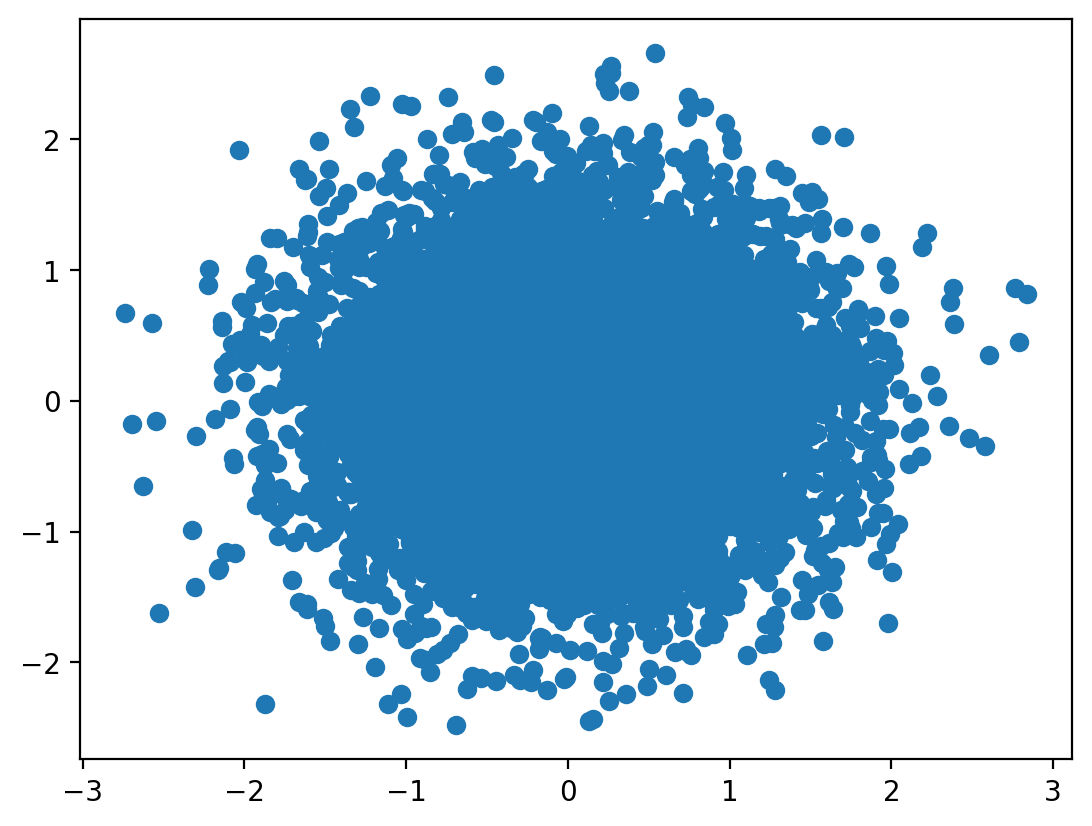

In [60]:
plot_latent(vae, dataloader)